#**CLASSIFICATION TASK 1 - Figurative vs non Figurative**

In this notebook, we experiment with different models to **classify tweets into figurative and non-figurative language** (the one we referred to as Classification Task 1). By employing various techniques, we aim to analyze the effectiveness of each model in capturing the nuances of language expression in tweet. <br>
Most of the models were trained on both the **post-feature selection and pre-feature selection datasets** to assess the effectiveness of our selection strategy. For some models, we also opted to investigate further by comparing the **impact of different vectorization techniques** (Word2Vec vs CountVectorizer). In the case of decision trees and SVM, we also trained classifiers on the reduced space containing only two variables (*Syno_Lower_Mean and Syn_Mean*), which are the features we created in the feature engineering step, to evaluate their classification potential.
<br>
<br>
Trained and tested models, along with their code and output (in order):

* k-Nearest Neighbors
* Support Vector Machine (SVM)
* Decision Tree
* Random Forest
* Logistic Regression
* BERT
* LSTM

Finally, a brief section is presented that involves the use of NLTK negation, as explained in more detail later.

#Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint, loguniform
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack, csr_matrix
from gensim.models import Word2Vec
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
# nltk.download('punkt')
# !pip install scikeras
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import glorot_uniform, he_uniform
from keras.optimizers import SGD
from keras.optimizers.schedules import ExponentialDecay
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from gensim.models import Word2Vec

from keras.optimizers import SGD
from keras.regularizers import l2

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay
)


from google.colab import drive
drive.mount("/content/drive", force_remount=True)


# KNN

## Pre Feature Selection

In [ ]:
train_csv = "dataset_first_task/traindata_frames_wordvect_syno_nofeatureselection.csv"
test_csv = "dataset_first_task/testdata_frames_wordvect_syno_nofeatureselection.csv"

df_train = pd.read_csv(train_csv, encoding='utf-8')
df_test = pd.read_csv(test_csv, encoding='utf-8')

df_train.rename(columns={'0': 'score'}, inplace=True)
df_test.rename(columns={'0': 'score'}, inplace=True)

X_train = df_train.drop(["frame","text", "id", "score"], axis=1)
X_test = df_test.drop(["score","id","frame","text"], axis=1)

y_train = df_train["score"]
y_test = df_test["score"]

X_train.head(5)

,Custom,Inclusion,Dispersal,Feigning,Sounds,Be_in_control,Pattern,Completeness,Time_period_of_action,Mass_motion,...,yelling,yes,young,youre,youtube,youve,yrs,yu,yum,zach
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Hyper param tuning process

''''
param_grid = {
    "n_neighbors": randint(5,20),
    "weights": ["uniform", "distance"],
    "metric": ["manhattan", "euclidean", "minkowski"]
}

grid = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter = 50,
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_

print(grid.best_params_, grid.best_score_)
'''

              precision    recall  f1-score   support

           0       0.59      0.63      0.61       228
           1       0.60      0.56      0.58       230

    accuracy                           0.59       458
   macro avg       0.59      0.59      0.59       458
weighted avg       0.59      0.59      0.59       458



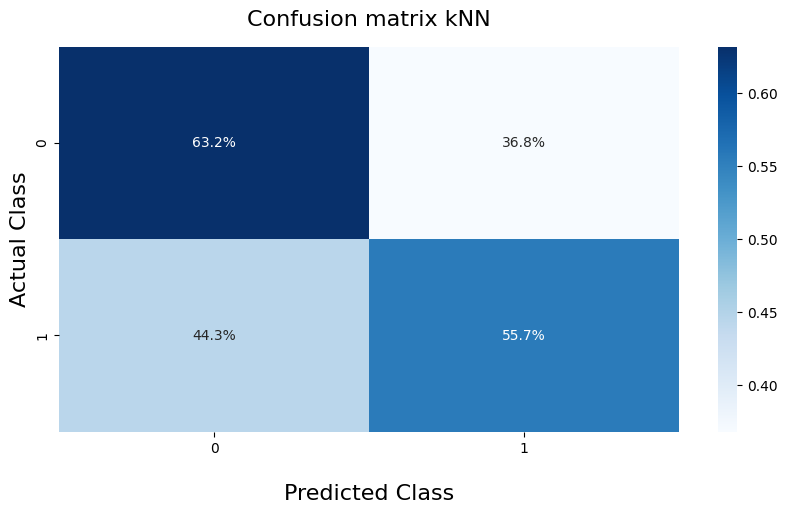

In [ ]:
# building the best model (best params)
knn = KNeighborsClassifier(n_neighbors=6, metric="manhattan", weights="uniform")
knn.fit(X_train, y_train) # training
y_pred = knn.predict(X_test) # prediction

print(classification_report(y_test, y_pred)) #a summary of performances
cf = confusion_matrix(y_test, y_pred, normalize='true')

# plot confusion matrix
plt.figure(figsize = (10,5))
sns.heatmap(cf, annot=True, cmap="Blues", xticklabels=knn.classes_, yticklabels=knn.classes_ , fmt='.1%' )
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix kNN', fontsize = 16, pad = 15)
plt.show()

## Post Feature Selection

In [ ]:
train_csv = "dataset_first_task/traindata_featureselection.csv"
test_csv = "dataset_first_task/testdata_featureselection.csv"

df_train_FS = pd.read_csv(train_csv, encoding='utf-8')
df_test_FS = pd.read_csv(test_csv, encoding='utf-8')

X_train_FS = df_train_FS.drop(["0", "text"], axis=1)
X_test_FS = df_test_FS.drop(["0", "text"], axis=1)

y_train_FS = df_train_FS["0"].map(lambda x: 0 if x <= 0 else 1)
y_test_FS = df_test_FS["0"].map(lambda x: 0 if x <= 0 else 1)

In [ ]:
# Hyper param tuning process

''''
param_grid = {
    "n_neighbors": randint(5,20),
    "weights": ["uniform", "distance"],
    "metric": ["manhattan", "euclidean", "minkowski"]
}

grid = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter = 50,
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_

print(grid.best_params_, grid.best_score_)
'''

              precision    recall  f1-score   support

           0       0.58      0.55      0.56       228
           1       0.57      0.60      0.58       230

    accuracy                           0.57       458
   macro avg       0.57      0.57      0.57       458
weighted avg       0.57      0.57      0.57       458



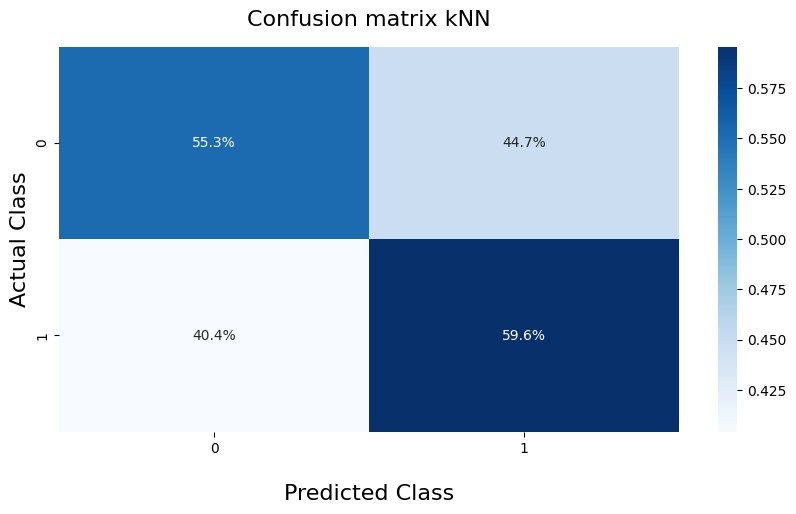

In [ ]:
# building the best model (best params)
knn = KNeighborsClassifier(n_neighbors=16, metric="manhattan", weights="uniform")
knn.fit(X_train_FS, y_train_FS) # training
y_pred_FS = knn.predict(X_test_FS) # prediction

print(classification_report(y_test_FS, y_pred_FS))
cf = confusion_matrix(y_test_FS, y_pred_FS, normalize='true')


plt.figure(figsize = (10,5))
sns.heatmap(cf, annot=True, cmap="Blues", xticklabels=knn.classes_, yticklabels=knn.classes_ , fmt='.1%' )
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix kNN', fontsize = 16, pad = 15)
plt.show()

# SVM

## Pre Feature Selection

In [ ]:
train_data = pd.read_csv("dataset_first_task/traindata_frames_wordvect_syno_nofeatureselection.csv")
test_data = pd.read_csv("dataset_first_task/testdata_frames_wordvect_syno_nofeatureselection.csv")

train_data.rename(columns={'0': 'score'}, inplace=True)
test_data.rename(columns={'0': 'score'}, inplace=True)

y_train = train_data['score']
y_test = test_data['score']

X_train = train_data.drop(columns=['score', 'id', 'frame', 'text'], axis=1)
X_test = test_data.drop(columns=['score', 'id', 'frame', 'text'], axis=1)

## Post Feature Selection

In [ ]:
train_data = pd.read_csv("dataset_first_task/traindata_featureselection.csv")
test_data = pd.read_csv("dataset_first_task/testdata_featureselection.csv")

train_data.rename(columns={'0': 'target'}, inplace=True)
test_data.rename(columns={'0': 'target'}, inplace=True)

y_train = train_data['target']
y_test = test_data['target']

X_train = train_data.drop(columns=['target', 'text'], axis=1)
X_test = test_data.drop(columns=['target', 'text'], axis=1)


              precision    recall  f1-score   support

           0       0.62      0.57      0.60       228
           1       0.61      0.65      0.63       230

    accuracy                           0.61       458
   macro avg       0.61      0.61      0.61       458
weighted avg       0.61      0.61      0.61       458



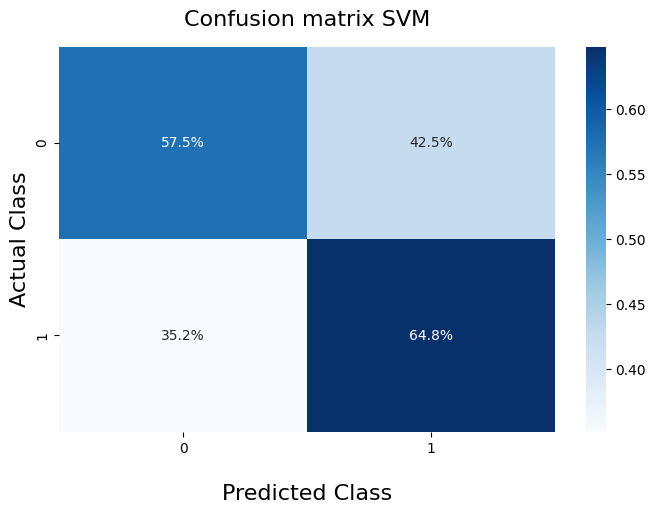

In [ ]:
# trying linear svm with default parameters to see how it performs
svm = LinearSVC()
svm_bin_clf = svm.fit(X_train, y_train)
bin_predictions_con = svm_bin_clf.predict(X_test)

print(classification_report(y_test, bin_predictions_con))

cm = confusion_matrix(y_test, bin_predictions_con, normalize='true')

plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=svm.classes_, yticklabels=svm.classes_ , fmt='.1%')
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix SVM', fontsize = 16, pad = 15)
plt.show()

In [ ]:
# HYPER PARAM TUNING
'''
param_grid = {
    'C' : [0.01, 0.1, 1, 10, 100],
    'kernel' : ['poly', 'rbf', 'sigmoid', 'linear'],
    'degree': [2, 3, 4, 5],
    'gamma' : [0, .1, 1, 10, 100],
}

clf = RandomizedSearchCV(SVC(), param_grid, cv=RepeatedStratifiedKFold(random_state=33),
                         n_iter=10, verbose=10, n_jobs=-1)

clf.fit(X_train, y_train)

print()
print('best:')
print(clf.best_estimator_)
print(''best score:', clf.best_score_) '''

# best:
# SVC(C=10, gamma=1)
# best score: 0.6342621331008428

              precision    recall  f1-score   support

           0       0.59      0.57      0.58       228
           1       0.58      0.60      0.59       230

    accuracy                           0.59       458
   macro avg       0.59      0.59      0.59       458
weighted avg       0.59      0.59      0.59       458



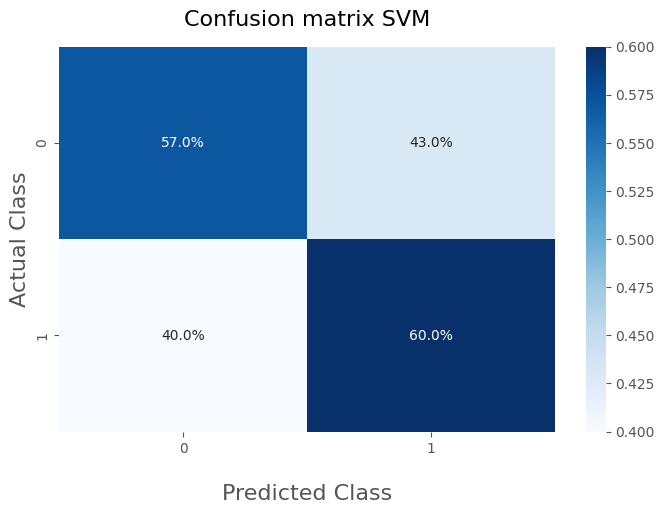

In [ ]:
# training svm with the best param found so far (from the above randomized search)

svm = SVC(C=10, gamma=0.1, kernel='linear')
svm_clf = svm.fit(X_train, y_train)
bin_predictions = svm_clf.predict(X_test)

print(classification_report(y_test, bin_predictions))

cm = confusion_matrix(y_test, bin_predictions, normalize='true')

plt.figure(figsize = (8,5))
plt.style.use('ggplot')
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=svm.classes_, yticklabels=svm.classes_ , fmt='.1%') #cmap="PiYG
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix SVM', fontsize = 16, pad = 15)
plt.show()

              precision    recall  f1-score   support

           0       0.59      0.57      0.58       228
           1       0.59      0.61      0.60       230

    accuracy                           0.59       458
   macro avg       0.59      0.59      0.59       458
weighted avg       0.59      0.59      0.59       458



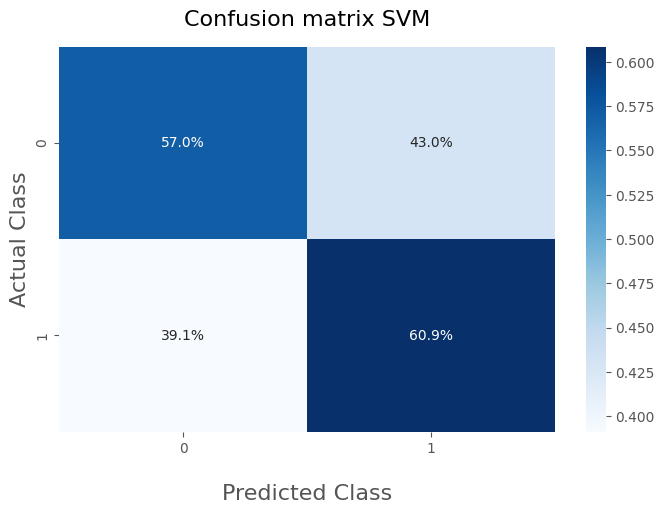

In [ ]:
# training svm with the best param found so far + CLASS WEIGHTS
# here we're trying to use class weights to make the classifier more sensitive to class 0

class_weights_dict = {0: 0.85, 1: 0.7} # empirical choice

svm = SVC(C=10, gamma=0.1, kernel='linear', class_weight=class_weights_dict)
svm_clf = svm.fit(X_train, y_train)
bin_predictions = svm_clf.predict(X_test)

print(classification_report(y_test, bin_predictions))

cm = confusion_matrix(y_test, bin_predictions, normalize='true')

plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=svm.classes_, yticklabels=svm.classes_ , fmt='.1%') #cmap="PiYG"
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix SVM', fontsize = 16, pad = 15)
plt.show()

<Figure size 800x500 with 0 Axes>

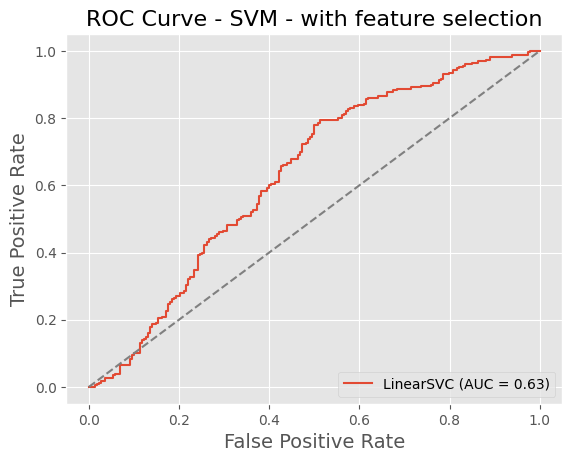

In [ ]:
# ROC CURVE
fpr_con, tpr_con, _ = roc_curve(y_test, bin_predictions_con)
roc_auc_con = auc(fpr_con, tpr_con)

plt.figure(figsize=(8, 5))
plt.style.use('ggplot')
roc_display = RocCurveDisplay.from_estimator(svm_bin_clf, X_test, y_test)
plt.title('ROC Curve - SVM - with feature selection', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Predictions') #dummy classifier
plt.show()

## Syn_mean and Syno_lower only

In [ ]:
train_data = pd.read_csv("dataset_first_task/traindata_featureselection.csv")
test_data = pd.read_csv("dataset_first_task/testdata_featureselection.csv")

train_data.rename(columns={'0': 'target'}, inplace=True)
test_data.rename(columns={'0': 'target'}, inplace=True)

y_train = train_data['target']
y_test = test_data['target']

X_train = train_data[['syno_lower_mean', 'syn_mean']]
X_test = test_data[['syno_lower_mean', 'syn_mean']]


In [ ]:
''' param_grid = {
    'C' : [0.01, 0.1, 1, 10, 100],
    'kernel' : ['poly', 'rbf', 'sigmoid', 'linear'],
    'degree': [2, 3, 4, 5],
    'gamma' : [0, .1, 1, 10, 100],
}

clf = RandomizedSearchCV(SVC(), param_grid, cv=RepeatedStratifiedKFold(random_state=33),
                         n_iter=5, verbose=10, n_jobs=-1)

clf.fit(X_train, y_train)

print()
print('best:')
print(clf.best_estimator_)
print(clf.best_score_) '''

# best:
#SVC(C=100, degree=5, gamma=1)

              precision    recall  f1-score   support

           0       0.52      0.56      0.54       228
           1       0.53      0.48      0.50       230

    accuracy                           0.52       458
   macro avg       0.52      0.52      0.52       458
weighted avg       0.52      0.52      0.52       458



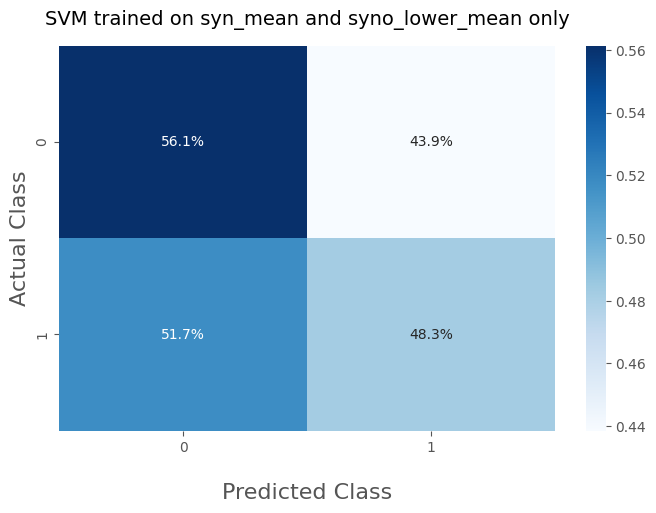

In [ ]:
svm = SVC(C=100, degree=5, gamma=1, class_weight = {0: 0.35, 1: 0.4})
svm_bin_clf = svm.fit(X_train, y_train)
bin_predictions = svm_bin_clf.predict(X_test)

print(classification_report(y_test, bin_predictions))

cm = confusion_matrix(y_test, bin_predictions, normalize='true')

plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=svm.classes_, yticklabels=svm.classes_ , fmt='.1%')
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('SVM trained on syn_mean and syno_lower_mean only', fontsize = 14, pad = 15)
plt.show()

#Logistic Regression

## Pre Feature Selection

### Count Vectorizer

In [ ]:
train_file_csv = "dataset_first_task/traindata_frames_syno_sentic_nofeatureselection.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_first_task/testdata_frames_syno_sentic_nofeatureselection.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')


text_features_train = df_train['text']
numerical_features_train = df_train.drop(['text', '0', 'frame'], axis=1).values

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["0"]

# vectorize text features for training and test data
vectorizer = CountVectorizer()
X_text_train_vec = vectorizer.fit_transform(X_text_train)
X_text_test_vec = vectorizer.transform(df_test['text'])

# separate text and numerical features for test data
numerical_features_test = df_test.drop(['text', '0', 'frame'], axis=1).values


X_train = hstack([X_text_train_vec, X_num_train])
X_test = hstack([X_text_test_vec, numerical_features_test])

# addestramento
model = LogisticRegression()
model.fit(X_train, y_train)

# predict
predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["0"], predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(df_test["0"], predictions))

Accuracy: 0.50

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.66       228
           1       0.00      0.00      0.00       230

    accuracy                           0.50       458
   macro avg       0.25      0.50      0.33       458
weighted avg       0.25      0.50      0.33       458



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Word Embeddings

In [ ]:

train_file_csv = "dataset_first_task/traindata_frames_syno_sentic_nofeatureselection.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_first_task/testdata_frames_syno_sentic_nofeatureselection.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['text']
numerical_features_train = csr_matrix(df_train.drop(['text', '0', 'frame'], axis=1).values)  # Use sparse matrix representation

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["0"]

# train Word2Vec on the text data for training
tokenized_text_train = [word_tokenize(text) for text in X_text_train]
word2vec_model = Word2Vec(sentences=tokenized_text_train, vector_size=100, window=5, min_count=1, workers=4)

# we define a function to average Word2Vec vectors, useful when you have to deal with variable-length vector
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64") # initialize an empty (all 0) vector with shape as number of features
    nwords = 0.

    for word in words:   # insert each wv word, if belongs to the vocabulary, in the initial feature vector and count the number of them
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)  # the averaged final vector

    return feature_vector

# convert text to Word2Vec vectors for training
X_text_train_vec = [average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in tokenized_text_train]
X_text_train_vec = csr_matrix(X_text_train_vec) # create the sparse matrix

tokenized_text_test = [word_tokenize(text) for text in df_test["text"]]
X_text_test_vec = [average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in tokenized_text_test]
X_text_test_vec = csr_matrix(X_text_test_vec)

numerical_features_test = csr_matrix(df_test.drop(['text', '0', 'frame'], axis=1).values)

X_train = hstack([X_text_train_vec, X_num_train]) # obtain the final matrix by horizontal stacking
X_test = hstack([X_text_test_vec, numerical_features_test])


model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)


accuracy = accuracy_score(df_test["0"], predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(df_test["0"], predictions))
# basically a random predictor

Accuracy: 0.50

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.66       228
           1       0.00      0.00      0.00       230

    accuracy                           0.50       458
   macro avg       0.25      0.50      0.33       458
weighted avg       0.25      0.50      0.33       458



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Post Feature Selection

### Count Vectorizer

In [ ]:
train_file_csv = "dataset_first_task/traindata_featureselection.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_first_task/testdata_featureselection.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

# separate text and numerical features for training adn test data
text_features_train = df_train['text']
numerical_features_train = df_train.drop(['text', '0'], axis=1).values

text_features_test = df_test['text']
numerical_features_test = df_test.drop(['text', '0'], axis=1).values

# vectorize text features for training and test data
vectorizer = CountVectorizer()
X_text_train_vec = vectorizer.fit_transform(text_features_train)
X_text_test_vec = vectorizer.transform(text_features_test)

# combine both types of features for training and test data using hstack
X_train = hstack([X_text_train_vec, numerical_features_train])
X_test = hstack([X_text_test_vec, numerical_features_test])


model = LogisticRegression() #training
model.fit(X_train, df_train["0"])

predictions = model.predict(X_test) #predict

accuracy = accuracy_score(df_test["0"], predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(df_test["0"], predictions))

Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.61      0.63       228
           1       0.64      0.69      0.66       230

    accuracy                           0.65       458
   macro avg       0.65      0.65      0.65       458
weighted avg       0.65      0.65      0.65       458



### Word Embeddings

In [ ]:
# split the data into training and testing sets
X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["0"]

# train Word2Vec on the text data
tokenized_text_train = [word_tokenize(text) for text in X_text_train]
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

# we define a function to average Word2Vec vectors
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# conversion text to Word2Vec vectors
X_text_train_vec = [average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in tokenized_text]
X_text_train_vec = csr_matrix(X_text_train_vec)

# separate text and numerical features for test data
text_features_test = df_test['text']
numerical_features_test = csr_matrix(df_test.drop(['text', '0'], axis=1).values)  # Use sparse matrix representation

# converion test text data to Word2Vec vectors
tokenized_test_text = [word_tokenize(text) for text in text_features_test]
X_text_test_vec = [average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in tokenized_test_text]
X_text_test_vec = csr_matrix(X_text_test_vec)


X_train = hstack([X_text_train_vec, X_num_train])
X_test = hstack([X_text_test_vec, numerical_features_test])

model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)


accuracy = accuracy_score(df_test["0"], predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(df_test["0"], predictions))


Accuracy: 0.59

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.52      0.56       228
           1       0.58      0.67      0.62       230

    accuracy                           0.59       458
   macro avg       0.59      0.59      0.59       458
weighted avg       0.59      0.59      0.59       458



# Decision Tree

## Pre Feature Selection

In [ ]:
train_csv = "dataset_first_task/traindata_frames_wordvect_syno_nofeatureselection.csv"
test_csv = "dataset_first_task/testdata_frames_wordvect_syno_nofeatureselection.csv"

df_test = pd.read_csv(train_csv, encoding='utf-8')
df_train = pd.read_csv(test_csv, encoding='utf-8')

y_train = df_train['0']
y_test = df_test['0']

df_train = df_train.iloc[:, 4:-1]
df_test = df_test.iloc[:, 4:-1]

In [ ]:
# hyper param tuning

'''param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 10),
    'min_samples_split': np.arange(2, 5),
    'min_samples_leaf': np.arange(1, 5),
}


grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search.fit(df_train, y_train)

print("migliori iperparametri:", grid_search.best_params_)
best_model = grid_search.best_estimator_
accuracy = best_model.score(df_test, y_test)
print("accuracy sul test set:", accuracy)'''


Migliori iperparametri: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 3}
Accuracy sul test set: 0.5917030567685589


In [ ]:
# building the best model so far
clf = DecisionTreeClassifier(criterion="gini", max_depth=7, min_samples_leaf=2, min_samples_split=3)
clf.fit(df_train, y_train)
bin_predictions = clf.predict(df_test)
cross_val_score(clf, df_test, y_test, cv=10)

print(classification_report(y_test, bin_predictions))

              precision    recall  f1-score   support

           0       0.58      0.66      0.62       228
           1       0.61      0.53      0.57       230

    accuracy                           0.60       458
   macro avg       0.60      0.60      0.59       458
weighted avg       0.60      0.60      0.59       458



## Post Feature Selection

In [ ]:
train_csv = "traindata_featureselection.csv"
test_csv = "traindata_featureselection.csv"

df_test = pd.read_csv(test_csv, encoding='utf-8')
df_train = pd.read_csv(train_csv, encoding='utf-8')

y_train = df_train['0']
y_test = df_test['0']

df_train = df_train.iloc[:, 1:-1]
df_test = df_test.iloc[:, 1:-1]

In [ ]:
# hyper param tuning

'''
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 10),
    'min_samples_split': np.arange(2, 5),
    'min_samples_leaf': np.arange(1, 5),
}

grid_search = GridSearchCV(clf, param_grid, cv=10)t
grid_search.fit(df_train, y_train)

print("Migliori iperparametri:", grid_search.best_params_)

best_model = grid_search.best_estimator_
accuracy = best_model.score(df_test, y_test)
print("Accuracy sul test set:", accuracy) '''


Migliori iperparametri: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 4}
Accuracy sul test set: 0.697198275862069


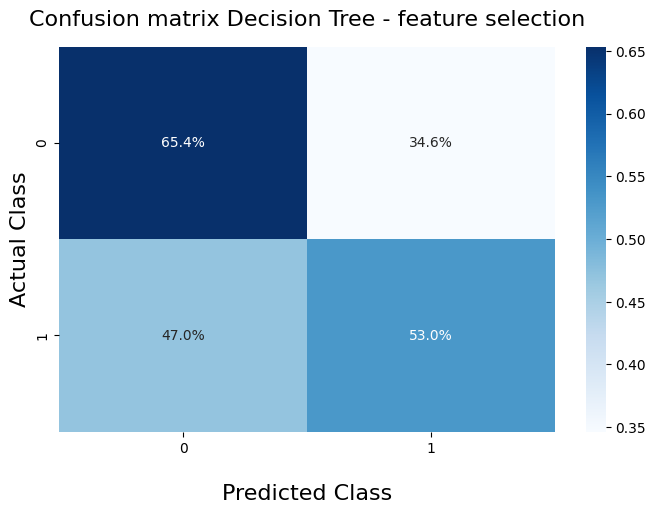

In [ ]:
cm = confusion_matrix(y_test, bin_predictions, normalize='true')

plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_ , fmt='.1%')
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix Decision Tree - feature selection', fontsize = 16, pad = 15)
plt.show()

## Syno_Lower_Mean and Syn_Mean only

In [ ]:
train_csv = "dataset_first_task/traindata_featureselection.csv"
test_csv = "dataset_first_task/traindata_featureselection.csv"

df_train = pd.read_csv(train_csv, encoding='utf-8')
df_test = pd.read_csv(test_csv, encoding='utf-8')

y_train = df_train['0']
y_test = df_test['0']

df_train = df_train[['syno_lower_mean', 'syn_mean']]
df_test = df_test[['syno_lower_mean', 'syn_mean']]

df_train.head(3)

,syno_lower_mean,syn_mean
0,0.321267,0.276458
1,0.110448,0.084037
2,0.047511,0.056156


In [ ]:
# hyper param tuning

'''param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 10),
    'min_samples_split': np.arange(2, 5),
    'min_samples_leaf': np.arange(1, 5),
}


grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search.fit(df_train, y_train)

print("Migliori iperparametri:", grid_search.best_params_)
best_model = grid_search.best_estimator_
accuracy = best_model.score(df_test, y_test)
print("Accuracy sul test set:", accuracy)'''


Migliori iperparametri: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 4}
Accuracy sul test set: 0.6637931034482759


In [ ]:
# building the best model so far

clf = DecisionTreeClassifier(criterion="entropy", max_depth=7, min_samples_leaf=3, min_samples_split=4)
clf.fit(df_train, y_train)
bin_predictions = clf.predict(df_test)
cross_val_score(clf, df_test, y_test, cv=10)

print(classification_report(y_test, bin_predictions))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       465
           1       0.67      0.64      0.66       463

    accuracy                           0.66       928
   macro avg       0.66      0.66      0.66       928
weighted avg       0.66      0.66      0.66       928



#Random Forest

## Pre Feature Selection

### Count Vectorizer

In [ ]:
train_file_csv = "dataset_first_task/traindata_frames_syno_sentic_nofeatureselection.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_first_task/testdata_frames_syno_sentic_nofeatureselection.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['text']
numerical_features_train = df_train.drop(['text', '0', 'frame'], axis=1).values

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["0"]

# CountVectorizer to convert text to a matrix of token counts for training
vectorizer = CountVectorizer()
X_text_train_vec = vectorizer.fit_transform(X_text_train)

X_text_test_vec = vectorizer.transform(df_test['text'])

numerical_features_test = df_test.drop(['text', '0', 'frame'], axis=1).values

X_train = np.hstack([X_text_train_vec.toarray(), X_num_train])
X_test = np.hstack([X_text_test_vec.toarray(), numerical_features_test])

model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["0"], predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(df_test["0"], predictions))

Accuracy: 0.68

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.59      0.64       228
           1       0.65      0.77      0.70       230

    accuracy                           0.68       458
   macro avg       0.68      0.68      0.67       458
weighted avg       0.68      0.68      0.67       458



### Word Embeddings

In [ ]:
train_file_csv = "dataset_first_task/traindata_frames_syno_sentic_nofeatureselection.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_first_task/testdata_frames_syno_sentic_nofeatureselection.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['text']
test_text = df_test["text"]
numerical_features_train = df_train.drop(['text', '0', 'frame'], axis=1).values

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["0"]

sentences_train = [word_tokenize(text) for text in X_text_train]
sentences_test = [word_tokenize(text) for text in test_text]
word2vec_model = Word2Vec(sentences_train, vector_size=100, window=5, min_count=1, workers=4)

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

X_text_train_vec = np.array([average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in sentences_train])

X_text_test_vec = np.array([average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in sentences_test])

numerical_features_test = df_test.drop(['text', '0', 'frame'], axis=1).values

X_train = np.hstack([X_text_train_vec, X_num_train])
X_test = np.hstack([X_text_test_vec, numerical_features_test])

model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["0"], predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(df_test["0"], predictions))

## Post Feature Selection

### Count Vectorizer

In [ ]:

train_file_csv = "dataset_first_task/traindata_featureselection.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_first_task/testdata_featureselection.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['text']
numerical_features_train = df_train.drop(['text', '0'], axis=1).values

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["0"]

#  CountVectorizer to convert text to a matrix of token counts for training and test
vectorizer = CountVectorizer()
X_text_train_vec = vectorizer.fit_transform(X_text_train)
X_text_test_vec = vectorizer.transform(df_test['text'])

# separate text and numerical features for test data
numerical_features_test = df_test.drop(['text', '0'], axis=1).values

# combine both types of features for training and test data
X_train = np.hstack([X_text_train_vec.toarray(), X_num_train])
X_test = np.hstack([X_text_test_vec.toarray(), numerical_features_test])

# train the RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(df_test["0"], predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(df_test["0"], predictions))

Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.54      0.61       228
           1       0.63      0.77      0.69       230

    accuracy                           0.65       458
   macro avg       0.66      0.65      0.65       458
weighted avg       0.66      0.65      0.65       458



### Word Embeddings

In [ ]:
train_file_csv = "dataset_first_task/traindata_featureselection.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_first_task/testdata_featureselection.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['text']
text_test = df_test['text']
numerical_features_train = df_train.drop(['text', '0'], axis=1).values

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["0"]

# Word2Vec model
sentences_train = [word_tokenize(text) for text in X_text_train]
sentences_test = [word_tokenize(text) for text in text_test]
word2vec_model = Word2Vec(sentences_train, vector_size=100, window=5, min_count=1, workers=4)

# we define a function to average word vectors for a document
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# vectorize text features using Word2Vec for training and test data
X_text_train_vec = np.array([average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in sentences_train])
X_text_test_vec = np.array([average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in sentences_test])

# separate text and numerical features for test data
numerical_features_test = df_test.drop(['text', '0'], axis=1).values

X_train = np.hstack([X_text_train_vec, X_num_train])
X_test = np.hstack([X_text_test_vec, numerical_features_test])

# train the RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# make predictions on the test data
predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["0"], predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(df_test["0"], predictions))

Accuracy: 0.62

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.49      0.56       228
           1       0.60      0.75      0.66       230

    accuracy                           0.62       458
   macro avg       0.63      0.62      0.61       458
weighted avg       0.63      0.62      0.61       458



#BERT

In [ ]:
train_csv = "dataset_first_task/traindata_featureselection.csv"
test_csv = "dataset_first_task/testdata_featureselection.csv"

df_test = pd.read_csv(test_csv, encoding='utf-8')
df_train = pd.read_csv(train_csv, encoding='utf-8')

y_train = df_train['0']
y_test = df_test['0']

Stai usando: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training Loss: 0.7121601186949631, Validation Loss: 0.6915302952130635
Epoch 2, Training Loss: 0.669273501840131, Validation Loss: 0.6754028757413229
Epoch 3, Training Loss: 0.6087714536436672, Validation Loss: 0.6940749287605286
Epoch 4, Training Loss: 0.5056440398610872, Validation Loss: 0.6149877150853474
Epoch 5, Training Loss: 0.38057623957765513, Validation Loss: 0.6569245000680287
Epoch 6, Training Loss: 0.27854354474051246, Validation Loss: 0.7012123763561249
Epoch 7, Training Loss: 0.18138033100243273, Validation Loss: 0.7937194426854451
Epoch 8, Training Loss: 0.13855374899917636, Validation Loss: 0.8444011886914571
Epoch 9, Training Loss: 0.0913102182334867, Validation Loss: 0.928123946984609
Epoch 10, Training Loss: 0.06324095593701148, Validation Loss: 0.9863479057947795
Epoch 11, Training Loss: 0.06598459376857199, Validation Loss: 1.0128713925679524
Epoch 12, Training Loss: 0.04498976989295976, Validation Loss: 1.123247214158376
Epoch 13, Training Loss: 0.037074

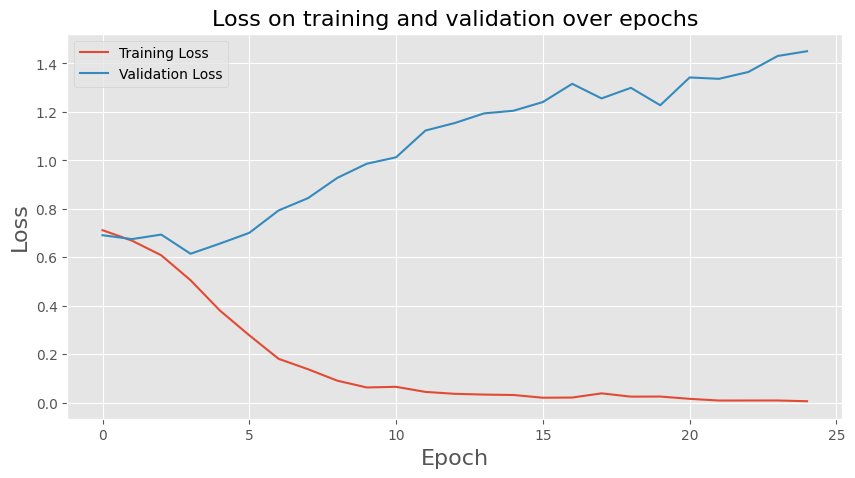

In [ ]:
# verifica disponibilità della GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Stai usando: {device}")

#  tokenizer BERT e modello pre-addestrato
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# preparazione dati
class CustomDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_length):
        self.encodings = tokenizer(list(text), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


max_length = 128
train_dataset = CustomDataset(df_train['text'], y_train, tokenizer, max_length)
val_dataset = CustomDataset(df_test['text'], y_test, tokenizer, max_length)
# carica i dati in DataLoader con l'opzione pin_memory
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5) #definizione dell'ottimizzatore

num_epochs = 25

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    average_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(average_val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {average_train_loss}, Validation Loss: {average_val_loss}')

# plot della loss
plt.figure(figsize=(10, 5))
plt.style.use('ggplot')
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.title('Loss on training and validation over epochs', fontsize = 16)
plt.legend()
plt.savefig('grafico_loss.png')
plt.show()


In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.2f}') #Accuracy: 0.68

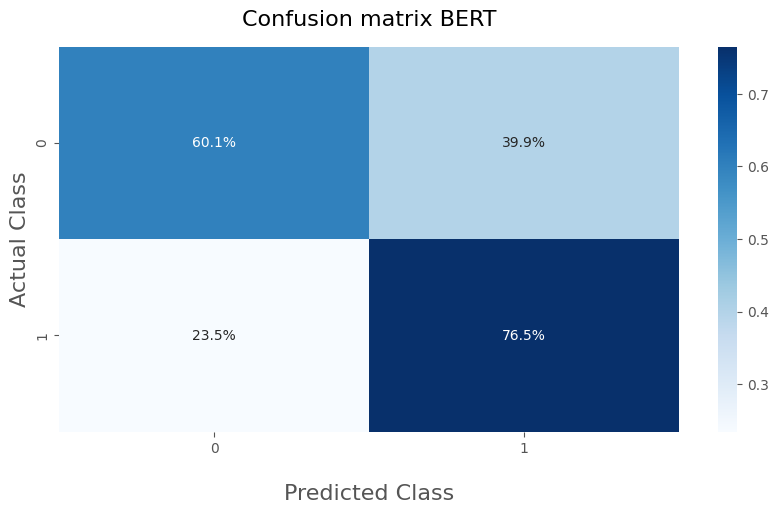

In [ ]:
cm = confusion_matrix(true_labels, predictions, normalize='true')

plt.figure(figsize=(10,5))
plt.style.use('ggplot')
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.1%') #cmap="PiYG
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix BERT', fontsize = 16, pad = 15)
plt.show()


#LSTM

## Pre Feature Selection

In [ ]:
# training lstm before feature selection is time consuming due to the high number of features (circa 7000)
''' file_csv = "dataset_first_task/traindata_frames_syno_sentic_nofeatureselection.csv"
df = pd.read_csv(file_csv, encoding='utf-8')
label_distribution = df['0'].value_counts()
string_columns = df.select_dtypes(include='object').columns

additiona_features = df.drop(['text', '0', 'frame'], axis=1).values
# additional features
additional_features = additiona_features.astype(float)
# labels
labels = df['0'].values.astype(float)
additiona_features.shape

# Vectorization (Word2vec)
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

# pad the sequences to have a consistent length
max_len = max(len(seq) for seq in sequences)
data_text = pad_sequences(sequences, maxlen=max_len)

tokenized_text = df['text'].apply(lambda x: x.split())

# train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=50, window=5, min_count=1, workers=4)

#embedding matrix
embedding_matrix = np.zeros((max_words, word2vec_model.vector_size))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word] '''

## Post Feature Selection

In [ ]:
file_csv = "dataset_first_task/traindata_featureselection.csv"
df = pd.read_csv(file_csv, encoding='utf-8')

additiona_features = df.drop(['text', '0'], axis=1).values
# additional features
additional_features = additiona_features.astype(float)
# labels
labels = df['0'].values.astype(float)
additiona_features.shape

(928, 41)

In [ ]:
#vectorization using word2vec
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

#padding
max_len = max(len(seq) for seq in sequences)
data_text = pad_sequences(sequences, maxlen=max_len)

#tokenization of text
tokenized_text = df['text'].apply(lambda x: x.split())

# training word2vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=50, window=5, min_count=1, workers=4)

# embedding matrix
embedding_matrix = np.zeros((max_words, word2vec_model.vector_size))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]

In [ ]:
# model selection and evaluation
# Define the number of folds for cross-validation
num_folds = 5
num_trials = 10


# hyper params values
custom_initial_lr = 0.006  # initial learning rate
custom_beta1 = 0.7  # Momentum (for SGD)
custom_epsilon = 1e-7
decay_steps = 10000  # number of steps before learning rate decay
decay_rate = 0.7  # learning rate decay factor

param_space = {
    'learning_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [40, 50, 60],
    'weight_decay': [0.05],
    'momentum': [0.8, 0.9],
    'droprate': [0.2, 0.3],
    'lstm_units': [150, 200],
    "ly1_units": [128, 64],
}


Training on Fold 1...

Training on Fold 2...

Training on Fold 3...

Training on Fold 4...

Training on Fold 5...
Trial 1: Mean Training Accuracy=0.6703, Mean Validation Accuracy=0.6109
Hyperparameters: {'learning_rate': 0.2, 'batch_size': 32, 'epochs': 50, 'weight_decay': 0.05, 'momentum': 0.8, 'droprate': 0.2, 'weight_initializer': 'glorot_uniform', 'lstm_units': 200, 'ly1_units': 128}


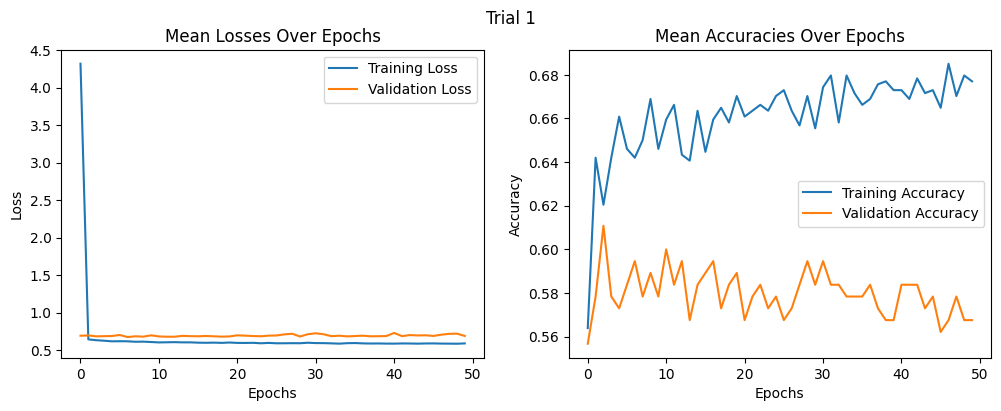


Training on Fold 1...

Training on Fold 2...

Training on Fold 3...

Training on Fold 4...

Training on Fold 5...
Trial 2: Mean Training Accuracy=0.6703, Mean Validation Accuracy=0.6206
Hyperparameters: {'learning_rate': 0.3, 'batch_size': 64, 'epochs': 50, 'weight_decay': 0.05, 'momentum': 0.8, 'droprate': 0.2, 'weight_initializer': 'glorot_uniform', 'lstm_units': 150, 'ly1_units': 64}


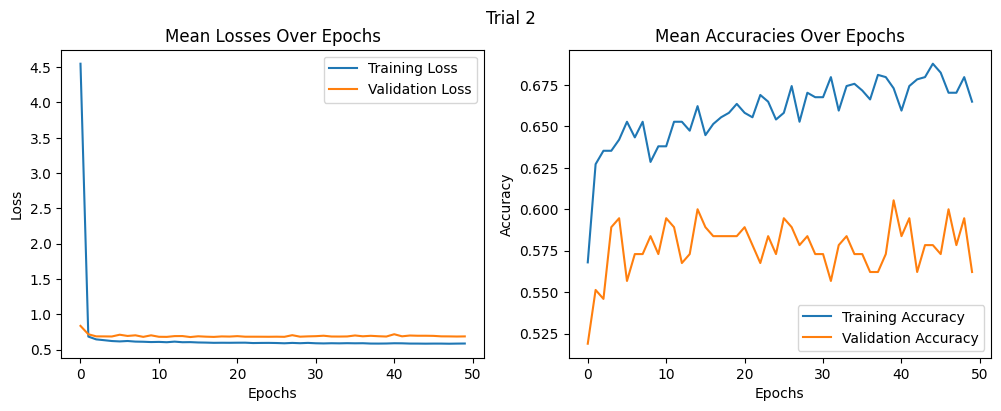


Training on Fold 1...

Training on Fold 2...

Training on Fold 3...

Training on Fold 4...

Training on Fold 5...
Trial 3: Mean Training Accuracy=0.6616, Mean Validation Accuracy=0.6260
Hyperparameters: {'learning_rate': 0.2, 'batch_size': 64, 'epochs': 60, 'weight_decay': 0.05, 'momentum': 0.8, 'droprate': 0.3, 'weight_initializer': 'he_uniform', 'lstm_units': 200, 'ly1_units': 128}


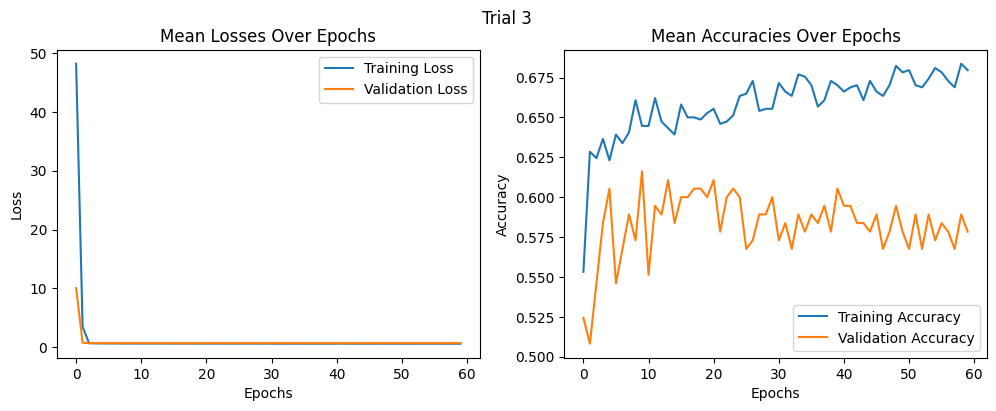


Training on Fold 1...

Training on Fold 2...

Training on Fold 3...

Training on Fold 4...

Training on Fold 5...
Trial 4: Mean Training Accuracy=0.6692, Mean Validation Accuracy=0.6303
Hyperparameters: {'learning_rate': 0.2, 'batch_size': 32, 'epochs': 50, 'weight_decay': 0.05, 'momentum': 0.8, 'droprate': 0.2, 'weight_initializer': 'glorot_uniform', 'lstm_units': 150, 'ly1_units': 128}


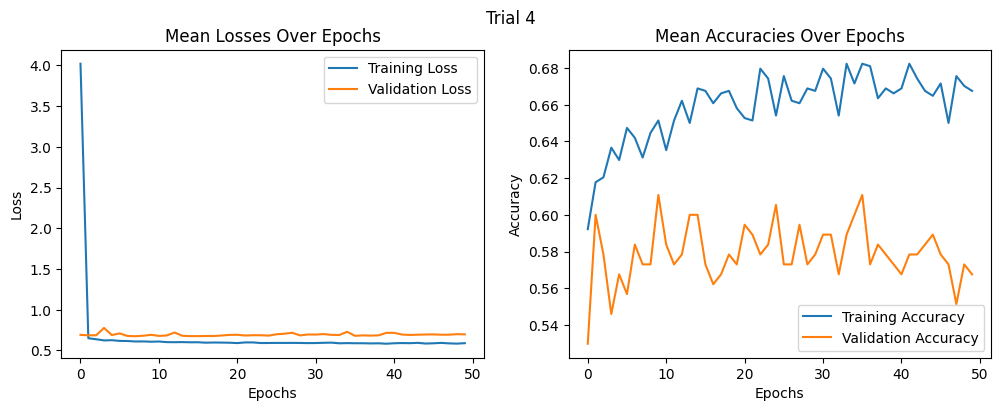


Training on Fold 1...

Training on Fold 2...

Training on Fold 3...

Training on Fold 4...

Training on Fold 5...
Trial 5: Mean Training Accuracy=0.6657, Mean Validation Accuracy=0.6260
Hyperparameters: {'learning_rate': 0.2, 'batch_size': 64, 'epochs': 50, 'weight_decay': 0.05, 'momentum': 0.8, 'droprate': 0.3, 'weight_initializer': 'glorot_uniform', 'lstm_units': 150, 'ly1_units': 128}


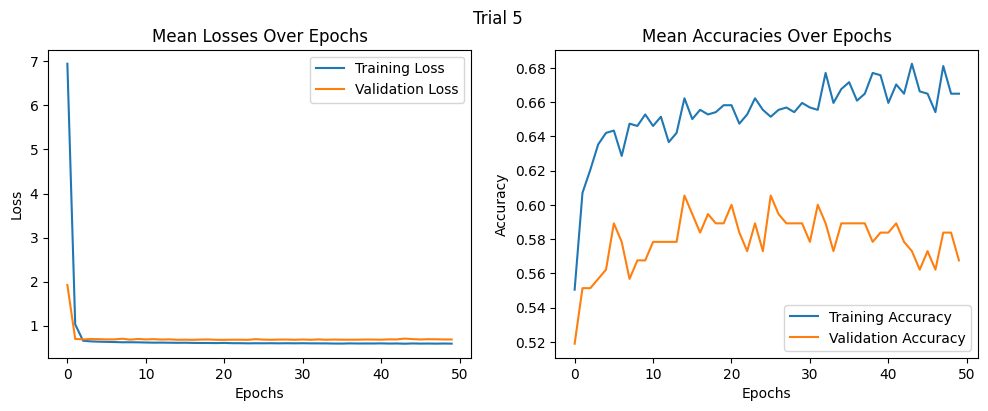


Training on Fold 1...

Training on Fold 2...

Training on Fold 3...

Training on Fold 4...

Training on Fold 5...
Trial 6: Mean Training Accuracy=0.6676, Mean Validation Accuracy=0.6293
Hyperparameters: {'learning_rate': 0.2, 'batch_size': 32, 'epochs': 40, 'weight_decay': 0.05, 'momentum': 0.9, 'droprate': 0.3, 'weight_initializer': 'he_uniform', 'lstm_units': 150, 'ly1_units': 64}


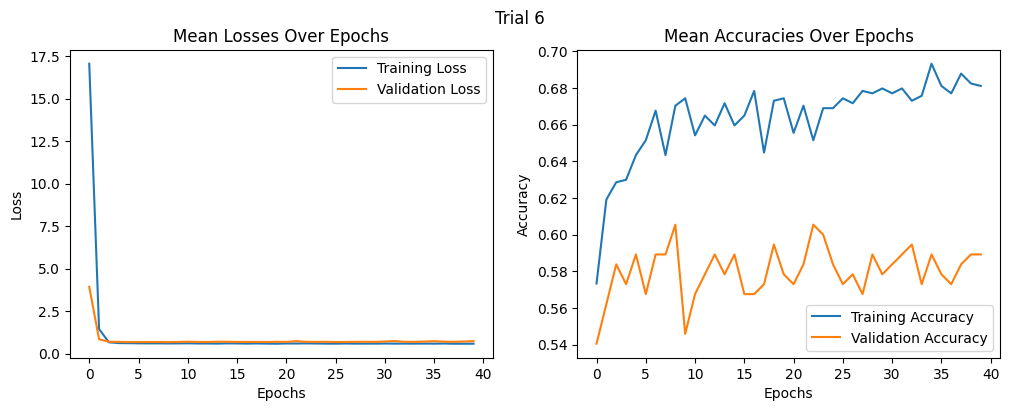


Training on Fold 1...

Training on Fold 2...

Training on Fold 3...

Training on Fold 4...

Training on Fold 5...
Trial 7: Mean Training Accuracy=0.6627, Mean Validation Accuracy=0.6184
Hyperparameters: {'learning_rate': 0.3, 'batch_size': 32, 'epochs': 40, 'weight_decay': 0.05, 'momentum': 0.9, 'droprate': 0.3, 'weight_initializer': 'glorot_uniform', 'lstm_units': 150, 'ly1_units': 64}


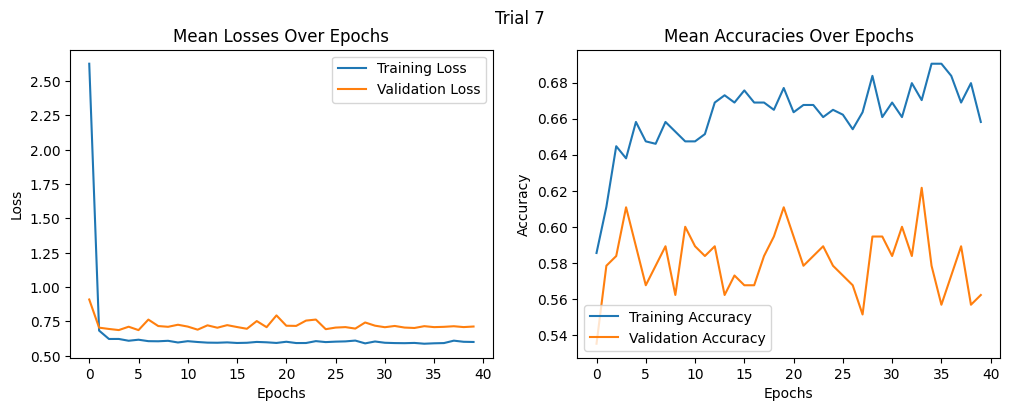


Training on Fold 1...

Training on Fold 2...

Training on Fold 3...

Training on Fold 4...

Training on Fold 5...
Trial 8: Mean Training Accuracy=0.6616, Mean Validation Accuracy=0.6325
Hyperparameters: {'learning_rate': 0.3, 'batch_size': 32, 'epochs': 40, 'weight_decay': 0.05, 'momentum': 0.8, 'droprate': 0.2, 'weight_initializer': 'he_uniform', 'lstm_units': 150, 'ly1_units': 64}


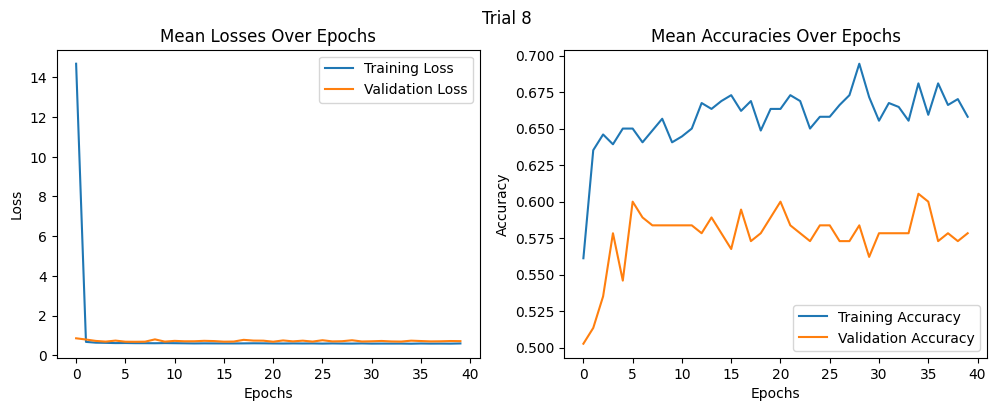


Training on Fold 1...

Training on Fold 2...

Training on Fold 3...

Training on Fold 4...

Training on Fold 5...
Trial 9: Mean Training Accuracy=0.6589, Mean Validation Accuracy=0.5969
Hyperparameters: {'learning_rate': 0.2, 'batch_size': 32, 'epochs': 40, 'weight_decay': 0.05, 'momentum': 0.9, 'droprate': 0.2, 'weight_initializer': 'glorot_uniform', 'lstm_units': 200, 'ly1_units': 64}


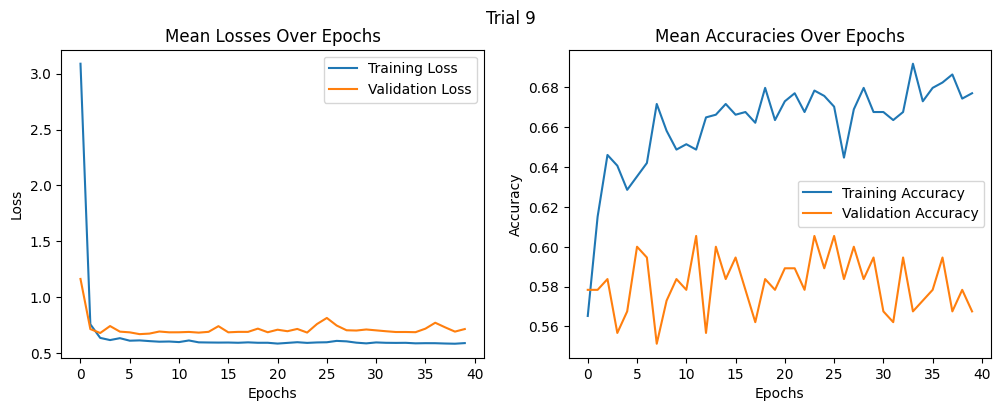


Training on Fold 1...

Training on Fold 2...

Training on Fold 3...

Training on Fold 4...

Training on Fold 5...
Trial 10: Mean Training Accuracy=0.6471, Mean Validation Accuracy=0.6304
Hyperparameters: {'learning_rate': 0.3, 'batch_size': 32, 'epochs': 60, 'weight_decay': 0.05, 'momentum': 0.9, 'droprate': 0.3, 'weight_initializer': 'he_uniform', 'lstm_units': 200, 'ly1_units': 128}


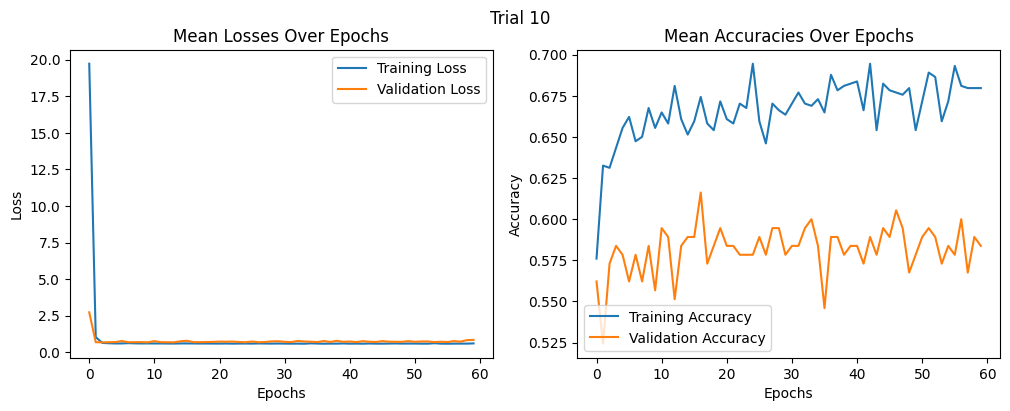


Overall Mean Training Accuracy: 0.6635
Overall Mean Validation Accuracy: 0.6221

Best Hyperparameters:
Trial: 8
Hyperparameters: {'learning_rate': 0.3, 'batch_size': 32, 'epochs': 40, 'weight_decay': 0.05, 'momentum': 0.8, 'droprate': 0.2, 'weight_initializer': 'he_uniform', 'lstm_units': 150, 'ly1_units': 64}
Mean Validation Accuracy: 0.6324963688850402


In [ ]:
# lists to store best hyperparams
best_hyperparameters = {
    'trial': 0,
    'params': {},
    'mean_validation_accuracy': 0
}

# StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

training_accuracies = []
validation_accuracies = []

for trial in range(num_trials):
    # random parameters
    params = {
        'learning_rate': np.random.choice(param_space['learning_rate']),
        'batch_size': np.random.choice(param_space['batch_size']),
        'epochs': np.random.choice(param_space['epochs']),
        'weight_decay': np.random.choice(param_space['weight_decay']),
        'momentum': np.random.choice(param_space['momentum']),
        'droprate': np.random.choice(param_space['droprate']),
        'weight_initializer': np.random.choice(['glorot_uniform', 'he_uniform']),
        'lstm_units': np.random.choice(param_space['lstm_units']),
        'ly1_units': np.random.choice(param_space['ly1_units'])
    }

    # lists to store fold-wise accuracies
    fold_training_accuracies = []
    fold_validation_accuracies = []

    # iterate over the folds
    for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(data_text, labels)):
        print(f"\nTraining on Fold {fold + 1}...")

        # split the data into training and validation sets
        X_train_text_fold, X_val_text_fold = data_text[train_indices], data_text[val_indices]
        X_train_additional_fold, X_val_additional_fold = additional_features[train_indices], additional_features[val_indices]
        y_train_fold, y_val_fold = labels[train_indices], labels[val_indices]

       # build the model with Word2Vec embeddings, Dropout, Batch Normalization, weight decay, and chosen weight initializer
        embedding_dim = word2vec_model.vector_size
        text_input = Input(shape=(max_len,))
        embedding_layer = Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(text_input)
        lstm_layer = LSTM(params["lstm_units"], kernel_regularizer=l2(params['weight_decay']), return_sequences=False, kernel_initializer=params['weight_initializer'])(embedding_layer)
        batch_norm_layer = BatchNormalization()(lstm_layer)
        dropout_layer_1 = Dropout(params['droprate'])(batch_norm_layer)
        dense_layer_1 = Dense(params["ly1_units"], activation='relu', kernel_regularizer=l2(params['weight_decay']))(dropout_layer_1)

        # input layers for each additional feature
        input_layers = [text_input]
        for i in range(additional_features.shape[1]):
            feature_input = Input(shape=(1,), name=f'feature_input_{i}')
            input_layers.append(feature_input)

        # concatenation all input layers
        concatenated = concatenate([dense_layer_1] + input_layers[1:])
        output = Dense(1, activation='sigmoid')(concatenated)

        model = Model(inputs=input_layers, outputs=output)

        # SGD optimizer with custom hyperparameters and learning rate schedule
        #learning_rate_schedule = ExponentialDecay(initial_learning_rate=params["learning_rate"], decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)
        custom_sgd = SGD(learning_rate=params["learning_rate"], momentum=params["momentum"], nesterov=True)

        # define EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True)   # Ferma e torna indietro se degrada dopo un tot epoche
        model.compile(optimizer=custom_sgd, loss='binary_crossentropy', metrics=['accuracy'])

        # training
        history = model.fit(
            [X_train_text_fold] + [X_train_additional_fold[:, i:i+1] for i in range(additional_features.shape[1])],
            y_train_fold,
            epochs=params["epochs"],
            batch_size=params["batch_size"],
            validation_data=(
                [X_val_text_fold] + [X_val_additional_fold[:, i:i+1] for i in range(additional_features.shape[1])],
                y_val_fold
            ),
            verbose=0,
            callbacks=[early_stopping]
        )

        # evaluate on training set
        _, train_accuracy = model.evaluate(
            [X_train_text_fold] + [X_train_additional_fold[:, i:i+1] for i in range(additional_features.shape[1])],
            y_train_fold,
            verbose=0
        )

        fold_training_accuracies.append(train_accuracy)

        # evaluate on validation set
        _, val_accuracy = model.evaluate(
            [X_val_text_fold] + [X_val_additional_fold[:, i:i+1] for i in range(additional_features.shape[1])],
            y_val_fold,
            verbose=0
        )
        fold_validation_accuracies.append(val_accuracy)

    mean_training_accuracy = np.mean(fold_training_accuracies)
    mean_validation_accuracy = np.mean(fold_validation_accuracies)

    training_accuracies.append(mean_training_accuracy)
    validation_accuracies.append(mean_validation_accuracy)
    print(f"Trial {trial+1}: Mean Training Accuracy={mean_training_accuracy:.4f}, Mean Validation Accuracy={mean_validation_accuracy:.4f}")
    print("Hyperparameters:", params)

    plt.figure(figsize=(12, 4))

# plot losses
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Mean Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot delle accuracies
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Mean Accuracies Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(f'Trial {trial + 1}')
    plt.show()

    # update best hyperparameters if current trial has higher validation accuracy
    if mean_validation_accuracy > best_hyperparameters['mean_validation_accuracy']:
        best_hyperparameters['trial'] = trial + 1
        best_hyperparameters['params'] = params
        best_hyperparameters['mean_validation_accuracy'] = mean_validation_accuracy

#  overall mean accuracies
print(f"\nOverall Mean Training Accuracy: {np.mean(training_accuracies):.4f}")
print(f"Overall Mean Validation Accuracy: {np.mean(validation_accuracies):.4f}")

# best hyperparameters
print("\nBest Hyperparameters:")
print("Trial:", best_hyperparameters['trial'])
print("Hyperparameters:", best_hyperparameters['params'])
print("Mean Validation Accuracy:", best_hyperparameters['mean_validation_accuracy'])

Epoch 1/40
24/24 [==============================] - 3s 50ms/step - loss: 22.0746 - accuracy: 0.5512 - val_loss: 4.8573 - val_accuracy: 0.6398
Epoch 2/40
24/24 [==============================] - 0s 17ms/step - loss: 1.6956 - accuracy: 0.6173 - val_loss: 0.8486 - val_accuracy: 0.6290
Epoch 3/40
24/24 [==============================] - 0s 15ms/step - loss: 0.6820 - accuracy: 0.6105 - val_loss: 0.6547 - val_accuracy: 0.5914
Epoch 4/40
24/24 [==============================] - 0s 16ms/step - loss: 0.6204 - accuracy: 0.6442 - val_loss: 0.6393 - val_accuracy: 0.6452
Epoch 5/40
24/24 [==============================] - 0s 15ms/step - loss: 0.6184 - accuracy: 0.6173 - val_loss: 0.6500 - val_accuracy: 0.6452
Epoch 6/40
24/24 [==============================] - 0s 15ms/step - loss: 0.6182 - accuracy: 0.6429 - val_loss: 0.6473 - val_accuracy: 0.6344
Epoch 7/40
24/24 [==============================] - 0s 15ms/step - loss: 0.6125 - accuracy: 0.6267 - val_loss: 0.6482 - val_accuracy: 0.5968
Epoch 8/40
2

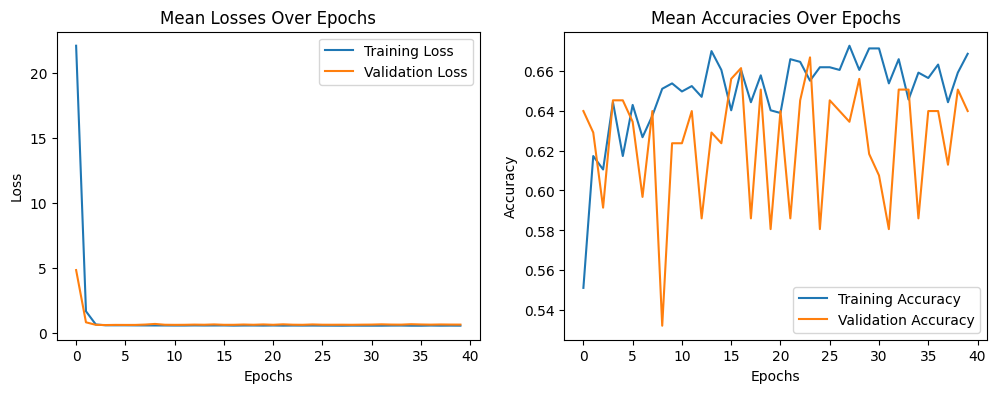

In [ ]:

# Training of final chosen model

params = {
    'learning_rate': 0.2,
    'batch_size': 32,
    'epochs': 40,
    'weight_decay': 0.05,
    'momentum': 0.9,       # Hyperparameters: {'learning_rate': 0.2, 'batch_size': 32, 'epochs': 40, 'weight_decay': 0.05, 'momentum': 0.9, 'droprate': 0.2, 'weight_initializer': 'he_uniform', 'lstm_units': 200, 'ly1_units': 64}

    'droprate': 0.2,
    'lstm_units': 200,
    "ly1_units": 64,
    'weight_initializer': 'he_uniform',

}


# we use the entire dataset for training and validation
X_train_text_fold, X_val_text_fold = data_text, data_text
X_train_additional_fold, X_val_additional_fold = additional_features, additional_features
y_train_fold, y_val_fold = labels, labels

# model
embedding_dim = word2vec_model.vector_size
text_input = Input(shape=(max_len,))
embedding_layer = Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(text_input)
lstm_layer = LSTM(units=200, kernel_regularizer=l2(0.05), return_sequences=False, kernel_initializer='he_uniform')(embedding_layer)
batch_norm_layer = BatchNormalization()(lstm_layer)
dropout_layer_1 = Dropout(0.2)(batch_norm_layer)
dense_layer_1 = Dense(units=64, activation='relu', kernel_regularizer=l2(0.05))(dropout_layer_1)

# create input layers for each additional feature
input_layers = [text_input]
for i in range(additional_features.shape[1]):
    feature_input = Input(shape=(1,), name=f'feature_input_{i}')
    input_layers.append(feature_input)

# concatenate all input layers
concatenated = concatenate([dense_layer_1] + input_layers[1:])
output = Dense(units=1, activation='sigmoid')(concatenated)

# create the model
model = Model(inputs=input_layers, outputs=output)
custom_sgd = SGD(learning_rate=0.2, momentum=0.9, nesterov=True)
model.compile(optimizer=custom_sgd, loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# training
history = model.fit(
    [data_text] + [additional_features[:, i:i+1] for i in range(additional_features.shape[1])],
    labels,
    epochs=40,
    batch_size=32,
    validation_split=0.2#,
    #callbacks=[early_stopping]
)

# evaluation
_, final_model_accuracy = model.evaluate(
    [data_text] + [additional_features[:, i:i+1] for i in range(additional_features.shape[1])],
    labels,
    verbose=0
)


print("Final Model Accuracy:", final_model_accuracy)

# Pplot mean losses and accuracies
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Mean Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Mean Accuracies Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# evalaution of the final model on the test set
test_data = pd.read_csv('dataset_first_task/testdata_featureselection.csv')

# preprocess test data
sequences_test = tokenizer.texts_to_sequences(test_data['text'])
data_text_test = pad_sequences(sequences_test, maxlen=max_len)
additional_features_test = test_data.drop(['text', '0'], axis=1).values.astype(float)

labels_test = test_data["0"].values

# evaluatyion the model on the test set
test_loss, test_accuracy = model.evaluate(
    [data_text_test] + [additional_features_test[:, i:i+1] for i in range(additional_features_test.shape[1])],
    labels_test,
    verbose=0
)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


predictions = model.predict([data_text_test] + [additional_features_test[:, i:i+1] for i in range(additional_features_test.shape[1])])
binary_predictions = (predictions > 0.5).astype(int)

accuracy = accuracy_score(labels_test, binary_predictions)
conf_matrix = confusion_matrix(labels_test, binary_predictions)
classification_report_str = classification_report(labels_test, binary_predictions)

print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report_str)


Test Loss: 0.6994675397872925
Test Accuracy: 0.567685604095459
15/15 [==============================] - 2s 12ms/step
Test Accuracy: 0.5676855895196506
Confusion Matrix:
 [[138  90]
 [108 122]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.61      0.58       228
           1       0.58      0.53      0.55       230

    accuracy                           0.57       458
   macro avg       0.57      0.57      0.57       458
weighted avg       0.57      0.57      0.57       458



15/15 [==============================] - 0s 9ms/step


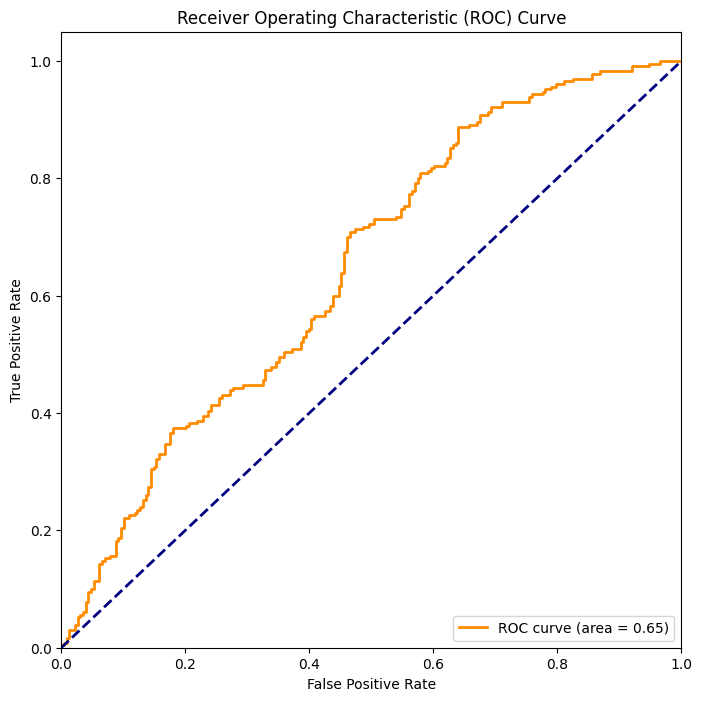

In [ ]:
y_pred_prob = model.predict([data_text_test] + [additional_features_test[:, i:i+1] for i in range(additional_features_test.shape[1])])

fpr, tpr, thresholds = roc_curve(labels_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# NLTK negation <br>
This section aims to showcase only some of the results achieved using **NLTK negation**. These techniques are designed to improve the model's capability to recognize shifts in sentiment influenced by the presence of negation words. The addition of **'\_NEG'** to the feature set arises from the implementation of negation handling on the text data with nltk.sentiment.util.mark\_negation function [https://www.nltk.org/api/nltk.sentiment.util.html]

In [ ]:
!pip install nltk
from nltk.sentiment.util import mark_negation

In [ ]:
train_file_csv = "dataset_first_task/traindata_featureselection.csv"
df_train = pd.read_csv(train_file_csv, encoding='utf-8')

test_file_csv = "dataset_first_task/testdata_featureselection.csv"
df_test = pd.read_csv(test_file_csv, encoding='utf-8')

# we define a function to apply mark_negation to a list of tokenized words
def apply_mark_negation(tokenized_tweet):
    marked_tweet = mark_negation(tokenized_tweet)
    # now we join the tokens back into a string
    return ' '.join(marked_tweet)

df_train['text'] = df_train['text'].apply(lambda x: apply_mark_negation(word_tokenize(x)))
df_test['text'] = df_test['text'].apply(lambda x: apply_mark_negation(word_tokenize(x)))

df_train.head(3) # new df

,0,syno_lower_mean,importance,capitalize,syn_mean,attitude,sensitivity,Communication_manner,dislike,hashtag,...,directorate,dreaminess,esteem,range,better-looking,rigid,look_good,love,inclusion,text
0,1,0.321267,0,0,0.276458,-0.020000,-0.023333,0,0,0,...,0,0,0,0,0,0,0,0,0,cant wait_NEG sun_NEG come_NEG 700_NEG humidit...
1,0,0.110448,0,0,0.084037,0.077273,0.005909,0,1,1,...,0,0,0,0,0,0,0,0,0,telangana muslim dalit majority one minority m...
2,1,0.047511,0,0,0.056156,0.067500,0.118200,0,0,0,...,0,0,0,0,0,0,0,0,0,patiently waiting tomorrows madrid oop surpris...


## Logistic Regression with CountVect

In [ ]:

#train_file_csv = "dataset_first_task/traindata_featureselection.csv"
#df_train = pd.read_csv(train_file_csv, encoding='utf-8')

#test_file_csv = "dataset_first_task/testdata_featureselection.csv"
#df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['text']
numerical_features_train = df_train.drop(['text', '0'], axis=1).values

text_features_test = df_test['text']
numerical_features_test = df_test.drop(['text', '0'], axis=1).values

vectorizer = CountVectorizer()
X_text_train_vec = vectorizer.fit_transform(text_features_train)
X_text_test_vec = vectorizer.transform(text_features_test)

X_train = hstack([X_text_train_vec, numerical_features_train])
X_test = hstack([X_text_test_vec, numerical_features_test])

model = LogisticRegression()
model.fit(X_train, df_train["0"])

predictions = model.predict(X_test)
accuracy = accuracy_score(df_test["0"], predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(df_test["0"], predictions))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.64

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.59      0.62       228
           1       0.63      0.69      0.66       230

    accuracy                           0.64       458
   macro avg       0.64      0.64      0.64       458
weighted avg       0.64      0.64      0.64       458



## Naive Bayes with CountVect

In [ ]:
#train_file_csv = "dataset_first_task/traindata_featureselection.csv"
#df_train = pd.read_csv(train_file_csv, encoding='utf-8')

#test_file_csv = "dataset_first_task/testdata_featureselection.csv"
#df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['text']
numerical_features_train = df_train.drop(['text', '0'], axis=1).values

# substitute negative values with their absolute values
numerical_features_train = np.abs(numerical_features_train)

text_features_test = df_test['text']
numerical_features_test = df_test.drop(['text', '0'], axis=1).values

numerical_features_test = np.abs(numerical_features_test)

vectorizer = CountVectorizer()
X_text_train_vec = vectorizer.fit_transform(text_features_train)
X_text_test_vec = vectorizer.transform(text_features_test)


X_train = hstack([X_text_train_vec, numerical_features_train])
X_test = hstack([X_text_test_vec, numerical_features_test])

model = MultinomialNB()
model.fit(X_train, df_train["0"])

predictions = model.predict(X_test)

accuracy = accuracy_score(df_test["0"], predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(df_test["0"], predictions))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.62

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.69      0.64       228
           1       0.64      0.54      0.59       230

    accuracy                           0.62       458
   macro avg       0.62      0.62      0.61       458
weighted avg       0.62      0.62      0.61       458





## Logistic Regression with Word Embeddings

In [ ]:

#train_file_csv = "dataset_first_task/traindata_featureselection.csv"
#df_train = pd.read_csv(train_file_csv, encoding='utf-8')

#test_file_csv = "dataset_first_task/testdata_featureselection.csv"
#df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['text']
numerical_features_train = csr_matrix(df_train.drop(['text', '0'], axis=1).values)  # Use sparse matrix representation

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["0"]
tokenized_text = [text.split() for text in X_text_train]
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

X_text_train_vec = [average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in tokenized_text]
X_text_train_vec = csr_matrix(X_text_train_vec)

text_features_test = df_test['text']
numerical_features_test = csr_matrix(df_test.drop(['text', '0'], axis=1).values)

tokenized_test_text = [text.split() for text in text_features_test]
X_text_test_vec = [average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in tokenized_test_text]
X_text_test_vec = csr_matrix(X_text_test_vec)

X_train = hstack([X_text_train_vec, X_num_train])
X_test = hstack([X_text_test_vec, numerical_features_test])

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(df_test["0"], predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(df_test["0"], predictions))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.59

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.52      0.56       228
           1       0.58      0.67      0.62       230

    accuracy                           0.59       458
   macro avg       0.59      0.59      0.59       458
weighted avg       0.59      0.59      0.59       458



## Random Forest with Word Embeddings

In [ ]:
#train_file_csv = "dataset_first_task/traindata_featureselection.csv"
#df_train = pd.read_csv(train_file_csv, encoding='utf-8')


#test_file_csv = "dataset_first_task/testdata_featureselection.csv"
#df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['text']
test_features_text = df_test['text']
numerical_features_train = df_train.drop(['text', '0'], axis=1).values

X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["0"]

# Word2Vec model
sentences_train = [word_tokenize(text) for text in X_text_train]
sentences_test = [word_tokenize(text) for text in test_features_text]
word2vec_model = Word2Vec(sentences_train, vector_size=100, window=5, min_count=1, workers=4)

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

X_text_train_vec = np.array([average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in sentences_train])
X_text_test_vec = np.array([average_word_vectors(tokens, word2vec_model, word2vec_model.wv.index_to_key, 100) for tokens in sentences_test])

numerical_features_test = df_test.drop(['text', '0'], axis=1).values

# Combine both types of features for training and test data
X_train = np.hstack([X_text_train_vec, X_num_train])
X_test = np.hstack([X_text_test_vec, numerical_features_test])

# Train the RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(df_test["0"], predictions)
print(f"Accuracy: {accuracy:.2f}")

# Display the classification report
print("\nClassification Report:")
print(classification_report(df_test["0"], predictions))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.60

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.57      0.59       228
           1       0.60      0.63      0.61       230

    accuracy                           0.60       458
   macro avg       0.60      0.60      0.60       458
weighted avg       0.60      0.60      0.60       458



## Random forest with CountVect

In [ ]:

#train_file_csv = "dataset_first_task/traindata_featureselection.csv"
#df_train = pd.read_csv(train_file_csv, encoding='utf-8')

# Load the test CSV file
#test_file_csv = "dataset_first_task/testdata_featureselection.csv"
#df_test = pd.read_csv(test_file_csv, encoding='utf-8')

text_features_train = df_train['text']
numerical_features_train = df_train.drop(['text', '0'], axis=1).values
X_text_train, X_num_train, y_train = text_features_train, numerical_features_train, df_train["0"]

# CountVectorizer to convert text to a matrix of token counts for training and test data
vectorizer = CountVectorizer()
X_text_train_vec = vectorizer.fit_transform(X_text_train)
X_text_test_vec = vectorizer.transform(df_test['text'])

numerical_features_test = df_test.drop(['text', '0'], axis=1).values
X_train = np.hstack([X_text_train_vec.toarray(), X_num_train])
X_test = np.hstack([X_text_test_vec.toarray(), numerical_features_test])

model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(df_test["0"], predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(df_test["0"], predictions))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.67

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.56      0.63       228
           1       0.64      0.77      0.70       230

    accuracy                           0.67       458
   macro avg       0.68      0.67      0.66       458
weighted avg       0.68      0.67      0.66       458

